# Example usage of the ofset free koopman MPC

In [75]:
import sys
import os
import numpy as np
#import pandas as pd
import joblib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from sklearn.preprocessing import StandardScaler

from neuromancer.system import Node, System
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

# Add 'src' to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
src_path = os.path.join(project_root, 'src')
sys.path.append(src_path)

import models
import helper
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading a Dataset

In [76]:
# Load experimental data from .mat files
from scipy.io import loadmat

# Path to experimental data
data_path = '../experimental_data/'


# Load test data (files ending with _2)
# Use the first 4000 points of training as a separate test set
T1_full = loadmat(data_path + 'T1_ident_3.mat')
T2_full = loadmat(data_path + 'T2_ident_3.mat')
T4_full = loadmat(data_path + 'T4_ident_3.mat')
u1_full = loadmat(data_path + 'u1_ident_3.mat')
u2_full = loadmat(data_path + 'u2_ident_3.mat')
u3_full = loadmat(data_path + 'u3_ident_3.mat')

T1_train = {'T1': T1_full['T1'][:4000][::10]}
T2_train = {'T2': T2_full['T2'][:4000][::10]}
T4_train = {'T4': T4_full['T4'][:4000][::10]}
u1_train = {'u1': u1_full['u1'].reshape(-1,1)[:4000][::10]}
u2_train = {'u2': u2_full['u2'].reshape(-1,1)[:4000][::10]}
u3_train = {'u3': u3_full['u3'].reshape(-1,1)[:4000][::10]}
# Test set: every 10th sample after first 4000
T1_test = {'T1': T1_full['T1'][4000:][::10]}
T2_test = {'T2': T2_full['T2'][4000:][::10]}
T4_test = {'T4': T4_full['T4'][4000:][::10]}
u1_test = {'u1': u1_full['u1'].reshape(-1,1)[4000:][::10]}
u2_test = {'u2': u2_full['u2'].reshape(-1,1)[4000:][::10]}
u3_test = {'u3': u3_full['u3'].reshape(-1,1)[4000:][::10]}

print("Experimental data loaded successfully!")
print(f"Training data variables: {list(T1_train.keys())}")
print(f"Test data variables: {list(T1_test.keys())}")

train = {
    'Y': np.concatenate([T1_train['T1'], T2_train['T2'], T4_train['T4']], axis=1),
    'U': np.concatenate([u1_train['u1'], u2_train['u2'], u3_train['u3']], axis=1)
}
test = {
    'Y': np.concatenate([T1_test['T1'], T2_test['T2'], T4_test['T4']], axis=1),
    'U': np.concatenate([u1_test['u1'], u2_test['u2'], u3_test['u3']], axis=1)
}


Experimental data loaded successfully!
Training data variables: ['T1']
Test data variables: ['T1']


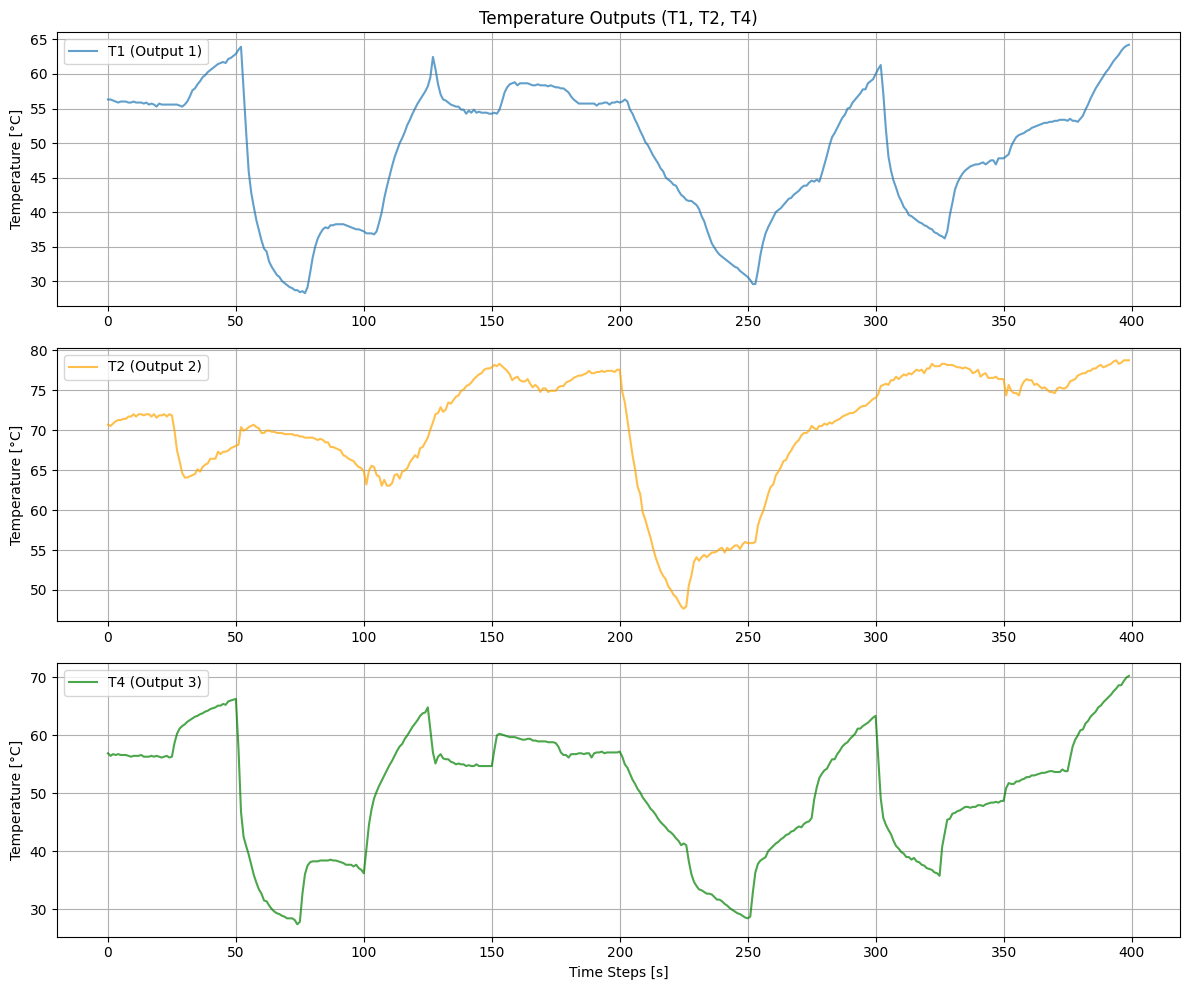

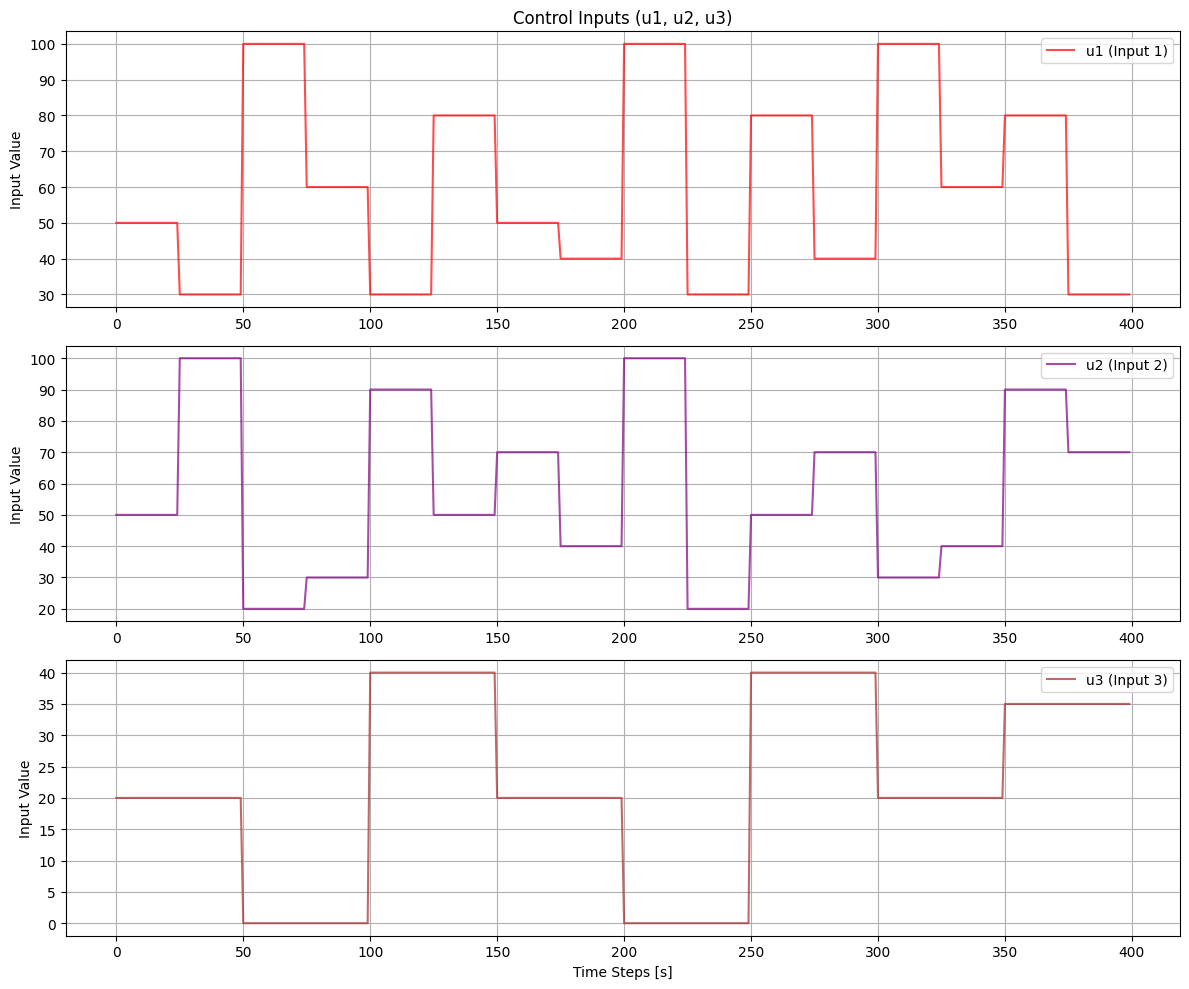

In [77]:
# Extract data from .mat dictionaries and prepare for plotting
# Outputs: T1, T2, T4
T1_data = T1_train['T1'].flatten()
T2_data = T2_train['T2'].flatten()
T4_data = T4_train['T4'].flatten()

# Inputs: u1, u2, u3
u1_data = u1_train['u1'].flatten()
u2_data = u2_train['u2'].flatten()
u3_data = u3_train['u3'].flatten()

# Determine the length to plot
part = min(3000, len(T1_data))

plt.figure(figsize=(12, 10))

# Plot outputs (T1, T2, T4)
plt.subplot(3, 1, 1)
plt.plot(T1_data[:part], label='T1 (Output 1)', alpha=0.7)
plt.title("Temperature Outputs (T1, T2, T4)")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(T2_data[:part], label='T2 (Output 2)', alpha=0.7, color='orange')
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(T4_data[:part], label='T4 (Output 3)', alpha=0.7, color='green')
plt.xlabel("Time Steps [s]")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot inputs (u1, u2, u3)
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(u1_data[:part], label='u1 (Input 1)', alpha=0.7, color='red')
plt.title("Control Inputs (u1, u2, u3)")
plt.ylabel("Input Value")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(u2_data[:part], label='u2 (Input 2)', alpha=0.7, color='purple')
plt.ylabel("Input Value")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(u3_data[:part], label='u3 (Input 3)', alpha=0.7, color='brown')
plt.xlabel("Time Steps [s]")
plt.ylabel("Input Value")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Preparing data for training koopman models

In [78]:
def get_data(train_sim, dev_sim, test_sim, nsteps, bs, scaler, scalerU):
    
    ny = train_sim['Y'].shape[1]
    nu = train_sim['U'].shape[1]
    
    nsim = train_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainX = scaler.transform(train_sim['Y'][:length])
    trainX = trainX.reshape(nbatch, nsteps, ny)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = scalerU.transform(train_sim['U'][:length])
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'Y': trainX, 'Y0': trainX[:, 0:1, :],
                              'U': trainU}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)
    
    nsim = dev_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps
    
    devX = scaler.transform(dev_sim['Y'][:length])
    devX = devX.reshape(nbatch, nsteps, ny)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = scalerU.transform(dev_sim['U'][:length])
    devU = devU[:length].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'Y': devX, 'Y0': devX[:, 0:1, :],
                            'U': devU}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    nsim = test_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps
    
    testX = scaler.transform(test_sim['Y'][:length])
    testX = testX.reshape(1, nbatch*nsteps, ny)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = scalerU.transform(test_sim['U'][:length])
    testU = testU.reshape(1, nbatch*nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'Y': testX, 'Y0': testX[:, 0:1, :],
                 'U': testU}
    
    trainX = scaler.transform(train_sim['Y'][:length])
    trainX = trainX.reshape(1, nbatch*nsteps, ny)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = scalerU.transform(train_sim['U'][:length])
    trainU = trainU.reshape(1, nbatch*nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data_forC = {'Y': trainX, 'Y0': trainX[:, 0:1, :],
                 'U': trainU}

    return train_loader, dev_loader, test_data, train_data_forC

In [79]:
nsteps = 80   # number of prediction horizon steps in the loss function
bs = 80      # minibatching batch size

In [80]:
# fit and save scalers for scaling the data on train dataset
scaler = StandardScaler()
scaler.fit(train['Y'])  
joblib.dump(scaler, '../data/scaler.pkl')

scalerU = StandardScaler()
scalerU.fit(train['U'])
joblib.dump(scalerU, '../data/scalerU.pkl')


['../data/scalerU.pkl']

In [81]:
train_new = {'Y': np.concatenate([train['Y'], test['Y']], axis=0),
             'U': np.concatenate([train['U'], test['U']], axis=0)}

In [82]:
train_loader, dev_loader, test_data, train_data = get_data(train_new, test, test, nsteps, bs, scaler, scalerU)

## Creating the model


In [83]:
# model parameters
nz = 35
ny = train['Y'].shape[1]
nu = train['U'].shape[1]

cons = 5
layers = [6*cons,12*cons,18*cons,24*cons]
layers_dec  = [24*cons,18*cons,12*cons,6*cons]

matrix_C = False

In [84]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(
    ny,
    nz,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
# initial condition encoder
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

In [85]:
# instantiate input encoder net f_u, representing the B matrix in the linear system
f_u = torch.nn.Linear(nu, nz, bias=False)
# initial condition encoder
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

In [86]:
# instantiate state decoder neural net f_y_inv
if not matrix_C:
    f_y_inv = blocks.MLP(nz, ny, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.ELU,
                    hsizes=layers_dec)
elif matrix_C:
    f_y_inv = torch.nn.Linear(nz, ny, bias=False)
else:
    raise ValueError('matrix_C must be boolean')

# predicted trajectory decoder
decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

In [87]:
# representing matrix A in the linear system
K = torch.nn.Linear(nz, nz, bias=False)

In [88]:
# symbolic Koopman model with control inputs
Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')

# latent Koopmann rollout
dynamics_model = System([Koopman], name='Koopman', nsteps=nsteps)

In [89]:
# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]

### Define Koopman system identification loss function terms

In [90]:
# variables
Y = variable("Y")  # observed
yhat = variable('yhat')  # predicted output
x_latent = variable('x_latent')  # encoded output trajectory in the latent space
u_latent = variable('u_latent')  # encoded input trajectory in the latent space
x = variable('x')  # Koopman latent space trajectory

xu_latent = x_latent + u_latent  # latent state trajectory

# output trajectory tracking loss
y_loss = 10. * (yhat[:, 1:-1, :] == Y[:, 1:, :]) ^ 2
y_loss.name = "y_loss"

# one-step tracking loss
onestep_loss = 1.*(yhat[:, 1, :] == Y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# reconstruction loss
reconstruction_loss = 1 * (yhat[:, 0, :] == Y[:, 0, :])^2
reconstruction_loss.name = "reconstruction_loss"

# latent trajectory tracking loss
x_loss = 1. * (x[:, 1:-1, :] == xu_latent[:, 1:, :]) ^ 2
x_loss.name = "x_loss"

### Construct System learning problem

In [91]:
# aggregate list of objective terms and constraints
objectives = [y_loss, x_loss, onestep_loss, reconstruction_loss]

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints=[])

# construct constrained optimization problem
problem = Problem(nodes, loss)

In [92]:
problem.nodes

ModuleList(
  (0): encoder_Y0(Y0) -> x
  (1): encoder_Y(Y) -> x_latent
  (2): encoder_U(U) -> u_latent
  (3): System(
    (nodes): ModuleList(
      (0): K(x, u_latent) -> x
    )
  )
  (4): decoder_y(x) -> yhat
)

### Solve the problem

In [93]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=300,
    warmup=100,
    epochs=5000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)


In [94]:
# train

best_model = trainer.train()
problem.load_state_dict(best_model)


epoch: 0  train_loss: 18.137441635131836
epoch: 1  train_loss: 17.5736141204834
epoch: 2  train_loss: 17.07291030883789
epoch: 3  train_loss: 16.607589721679688
epoch: 4  train_loss: 16.159650802612305
epoch: 5  train_loss: 15.71732234954834
epoch: 6  train_loss: 15.275015830993652
epoch: 7  train_loss: 14.832029342651367
epoch: 8  train_loss: 14.390824317932129
epoch: 9  train_loss: 13.956526756286621
epoch: 10  train_loss: 13.533863067626953
epoch: 11  train_loss: 13.124918937683105
epoch: 12  train_loss: 12.72855281829834
epoch: 13  train_loss: 12.339279174804688
epoch: 14  train_loss: 11.951019287109375
epoch: 15  train_loss: 11.559037208557129
epoch: 16  train_loss: 11.169119834899902
epoch: 17  train_loss: 10.79818058013916
epoch: 18  train_loss: 10.459173202514648
epoch: 19  train_loss: 10.145223617553711
epoch: 20  train_loss: 9.827953338623047
epoch: 21  train_loss: 9.477608680725098
epoch: 22  train_loss: 9.072953224182129
epoch: 23  train_loss: 8.596900939941406
epoch: 24  t

<All keys matched successfully>

### Saving model and evaluation of the training

In [95]:
# save model 
torch.save(best_model, "../data/model_baseline.pth")

# pull matrices
A = K.weight.detach().numpy()
B = f_u.weight.detach().numpy()
if matrix_C:
    C = f_y_inv.weight.detach().numpy()
    
elif not matrix_C:
    # get approximate C matrix from training data
    problem.nodes[3].nsteps = train_data['Y'].shape[1]
    train_outputs = problem.step(train_data)

    Y = train_data['Y'].reshape(-1, ny).detach().numpy()
    Z = train_outputs['x'][:,:-1,:].detach().numpy().reshape(-1, nz)
    rankZ = np.linalg.matrix_rank(Z)
    if rankZ < nz:
        print('Rank deficient Z matrix, can result in bad fitted C matrix!')
    C, residuals, rank, s = np.linalg.lstsq(Z, Y, rcond=None)
    C = C.T

else:
    raise ValueError('matrix_C must be boolean')

Rank deficient Z matrix, can result in bad fitted C matrix!


In [96]:
rankZ

np.int64(31)

In [97]:
from numpy.linalg import matrix_rank

# Compute the controllability matrix
n_states = A.shape[0]
controllability_matrix = np.hstack([np.linalg.matrix_power(A, i) @ B for i in range(n_states)])

# Check the rank of the controllability matrix
controllability_rank = matrix_rank(controllability_matrix)

print(f"Controllability Matrix Rank: {controllability_rank}")
print(f"System is {'controllable' if controllability_rank == n_states else 'not controllable'}")

# Compute the observability matrix
observability_matrix = np.vstack([C @ np.linalg.matrix_power(A, i) for i in range(n_states)])

# Check the rank of the observability matrix
observability_rank = matrix_rank(observability_matrix)

print(f"Observability Matrix Rank: {observability_rank}")
print(f"System is {'observable' if observability_rank == n_states else 'not observable'}")

Controllability Matrix Rank: 33
System is not controllable
Observability Matrix Rank: 30
System is not observable


In [98]:
# # Evaluate Jacobian for each latent state
# J_all = np.stack([
#     helper.evaluate_jacobian(problem.nodes[4], torch.from_numpy(xi).float())
#     for xi in x_train
# ])

# # Compute mean Jacobian
# C = np.mean(J_all, axis=0)
# print("Mean Jacobian J_mean:\n", C) # mean bias?

In [99]:
np.save('../data/A_baseline.npy', A)
np.save('../data/B_baseline.npy', B)
np.save('../data/C_baseline.npy', C)

In [100]:
# update the rollout length based on the test data
problem.nodes[3].nsteps = test_data['Y'].shape[1]

In [101]:
# do the prediction
test_outputs = problem.step(test_data)

pred_traj = test_outputs['yhat'][:, 1:-1, :].detach().numpy().reshape(-1, ny).T
true_traj = test_data['Y'][:, 1:pred_traj.shape[1]+1, ].detach().numpy().reshape(-1, ny).T
input_traj = test_data['U'].detach().numpy().reshape(-1, nu).T
pred_x = test_outputs['x'][:, 1:-1, :].detach().numpy().reshape(-1, nz).T

In [102]:
pred_traj_C = np.dot(C, pred_x)

In [103]:
x_mean = np.mean(pred_x, axis=1, keepdims=True)
x_med = np.median(pred_x, axis=1, keepdims=True)

In [104]:
def get_y_from_x(problem, x: np.ndarray) -> np.ndarray:
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"].detach().numpy().reshape(1, -1)

In [105]:
J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(x_mean[:,0]).float(),
)
# Get all latent states from training data
x_train = train_outputs['x'].detach().numpy().reshape(-1, nz)

# Evaluate Jacobian for each latent state
J_all = np.stack([
    helper.evaluate_jacobian(problem.nodes[4], torch.from_numpy(xi).float())
    for xi in x_train
])

bias_all = np.stack([
    get_y_from_x(problem, xi.reshape(-1,1))
    for xi in x_train
])

# Compute mean Jacobian
J_mean = np.mean(J_all, axis=0)
print("Mean Jacobian J_mean:\n", J_mean) # mean bias?

bias_mean = np.mean(bias_all, axis=0)
print("Mean Bias:\n", bias_mean)


pred_traj_J = np.dot(J_mean, pred_x - x_mean) #+ bias_mean.T

Mean Jacobian J_mean:
 [[ 9.92261991e-02 -3.53319138e-01 -1.78183958e-01  1.28904358e-01
  -1.13997936e-01 -2.40994796e-01  1.93289205e-01 -1.14256330e-01
  -5.11180349e-02  1.81440994e-01  1.04501538e-01  1.35314897e-01
   5.96522748e-01 -6.91541284e-02  6.44249320e-01  3.27695608e-01
  -7.85263404e-02 -1.40306696e-01 -3.23151350e-02  5.69752455e-01
  -8.33789539e-03 -8.97461101e-02  4.96603727e-01 -1.84745491e-01
   5.67435920e-02 -4.35594022e-01 -1.41528428e-01 -1.08987503e-01
   1.04965061e-01  3.03833008e-01 -3.31739873e-01 -2.15102673e-01
   4.53060538e-01  3.43798935e-01 -3.00991148e-01]
 [ 2.23493353e-01  4.47601020e-01  1.54619053e-01  1.34708375e-01
  -1.25267938e-01  2.87193298e-01  5.24452746e-01 -1.54490471e-01
  -2.87014723e-01 -6.25371560e-02 -9.40130576e-02 -3.30767661e-01
  -2.93679297e-01  9.76472199e-02 -1.66350469e-01  3.07144552e-01
  -4.51129138e-01 -1.05495580e-01  1.23271324e-01  8.86438712e-02
  -4.18687224e-01  3.47708225e-01 -2.44375974e-01  6.29342258e-01
  

In [106]:
x_lin = np.zeros((nz,1))
J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(x_lin[:,0]).float(),
)

bias = get_y_from_x(problem, x_lin)
pred_traj_J = np.dot(J, pred_x - x_lin) + bias.T

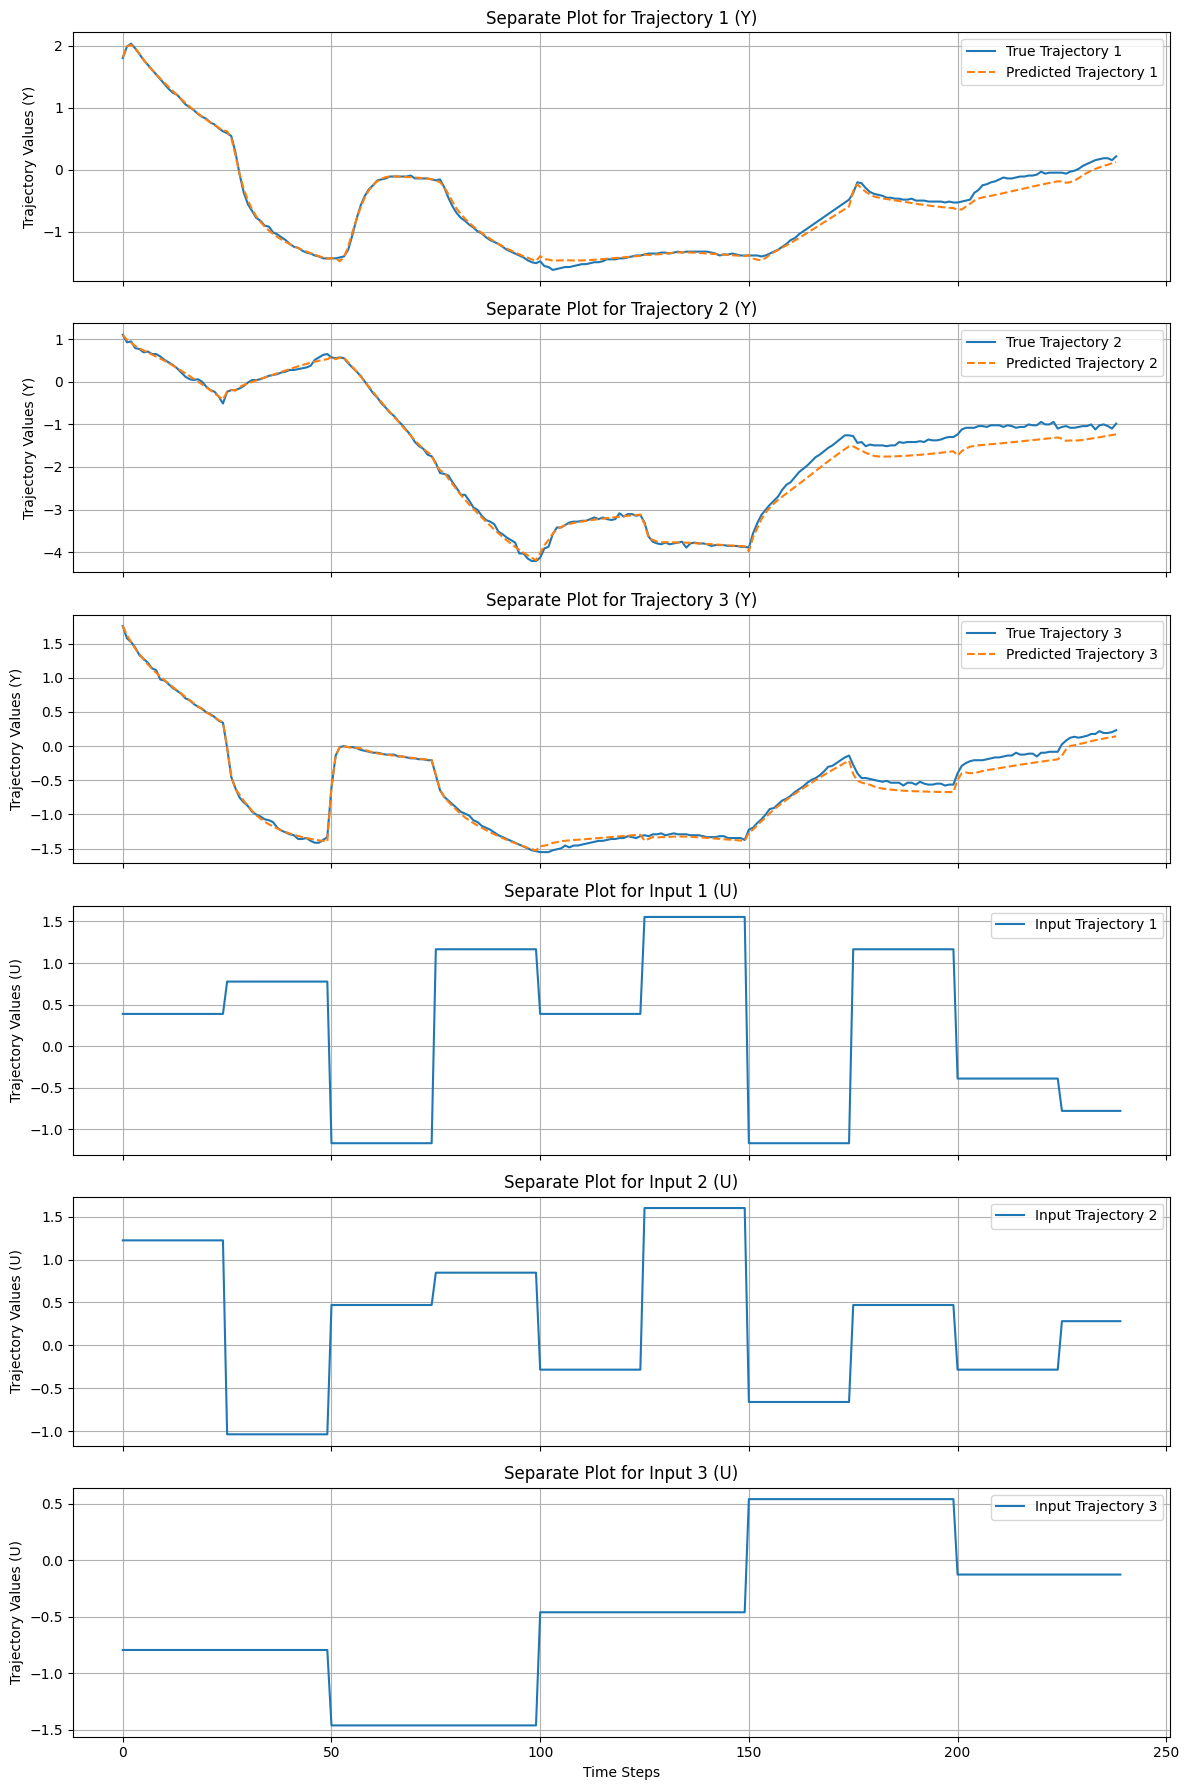

In [107]:
fig, axs = plt.subplots(ny + nu, 1, figsize=(12, 3 * (ny + nu)), sharex=True)

# Separate plots for each vector in Y
for i in range(ny):
    axs[i].plot(true_traj[i], label=f'True Trajectory {i + 1}', linestyle='-')
    axs[i].plot(pred_traj[i], label=f'Predicted Trajectory {i + 1}', linestyle='--')
    # axs[i].plot(pred_traj_C[i], label=f'Predicted Trajectory {i + 1} C', linestyle='--')
    #axs[i].plot(pred_traj_J[i], label=f'Predicted Trajectory {i + 1} J', linestyle='--')
    axs[i].set_title(f'Separate Plot for Trajectory {i + 1} (Y)')
    axs[i].legend()
    axs[i].grid()

# Separate plots for each vector in U
for i in range(nu):
    axs[ny + i].plot(input_traj[i], label=f'Input Trajectory {i + 1}', linestyle='-')
    axs[ny + i].set_title(f'Separate Plot for Input {i + 1} (U)')
    axs[ny + i].legend()
    axs[ny + i].grid()

# Add labels
axs[-1].set_xlabel('Time Steps')
for i in range(ny):
    axs[i].set_ylabel('Trajectory Values (Y)')
for i in range(nu):
    axs[ny + i].set_ylabel('Trajectory Values (U)')

plt.tight_layout()
plt.show()


In [108]:
# calculate MAE of predicted trajectories
mae_pred = np.mean(np.abs(true_traj[:, :] - pred_traj[:, :]), axis=1)
mae_pred_C = np.mean(np.abs(true_traj[:, :] - pred_traj_C[:, :]), axis=1)
mae_pred_J = np.mean(np.abs(true_traj[:, :] - pred_traj_J[:, :]), axis=1)
print(f'MAE of predicted trajectory (excluding first 20 steps): {sum(mae_pred)}')
print(f'MAE of predicted trajectory C (excluding first 20 steps): {sum(mae_pred_C)}')
print(f'MAE of predicted trajectory J (excluding first 20 steps): {sum(mae_pred_J)}')

MAE of predicted trajectory (excluding first 20 steps): 0.23963922262191772
MAE of predicted trajectory C (excluding first 20 steps): 1.5206791162490845
MAE of predicted trajectory J (excluding first 20 steps): 2.016582955690046


In [109]:
# Calculate variance of mismatch (error) between test data and predicted data
var_error_pred = np.var(true_traj - pred_traj, axis=1)
var_error_pred_C = np.var(true_traj - pred_traj_C, axis=1)
var_error_pred_J = np.var(true_traj - pred_traj_J, axis=1)

print(f'Variance of mismatch (True - Predicted): {var_error_pred}')
print(f'Variance of mismatch (True - Predicted C): {var_error_pred_C}')
print(f'Variance of mismatch (True - Predicted J): {var_error_pred_J}')



Variance of mismatch (True - Predicted): [0.00538297 0.02530155 0.00397864]
Variance of mismatch (True - Predicted C): [0.26414672 3.0290596  0.22245425]
Variance of mismatch (True - Predicted J): [0.29788879 0.42170147 0.2821048 ]


In [110]:
# Calculate mean squared error (MSE) of all test predictions
mse_pred = np.mean((true_traj - pred_traj) ** 2)
mse_pred_C = np.mean((true_traj - pred_traj_C) ** 2)
mse_pred_J = np.mean((true_traj - pred_traj_J) ** 2)

print(f'MSE of predicted trajectory: {mse_pred}')
print(f'MSE of predicted trajectory C: {mse_pred_C}')
print(f'MSE of predicted trajectory J: {mse_pred_J}')


MSE of predicted trajectory: 0.016235854476690292
MSE of predicted trajectory C: 1.2770256996154785
MSE of predicted trajectory J: 0.7674661300660127


In [111]:
MAE of predicted trajectory (excluding first 20 steps): 0.5619996786117554
MAE of predicted trajectory C (excluding first 20 steps): 1.1141608953475952



SyntaxError: invalid syntax (160099850.py, line 1)

MAE of predicted trajectory: 1.2085823863744736
MAE of predicted trajectory C: 1.4369688928127289

MAE of predicted trajectory: 0.5287503898143768
MAE of predicted trajectory C: 0.9669474512338638

MAE of predicted trajectory (excluding first 20 steps): 0.799770787358284
MAE of predicted trajectory C (excluding first 20 steps): 1.0216962099075317

increasing layer size 4x
MAE of predicted trajectory (excluding first 20 steps): 0.6437841355800629
MAE of predicted trajectory C (excluding first 20 steps): 1.082578495144844




In [ ]:
# Define lower and upper bounds for true_traj values
lower_bound = -0.50
upper_bound = 0.50

# Create mask for values within the specified range
mask = (true_traj >= lower_bound) & (true_traj <= upper_bound)

# Compute MAE only for masked values
mae_pred_masked = [np.mean(np.abs(true_traj[i][mask[i]] - pred_traj[i][mask[i]])) for i in range(true_traj.shape[0])]
mae_pred_C_masked = [np.mean(np.abs(true_traj[i][mask[i]] - pred_traj_C[i][mask[i]])) for i in range(true_traj.shape[0])]
mae_pred_J_masked = [np.mean(np.abs(true_traj[i][mask[i]] - pred_traj_J[i][mask[i]])) for i in range(true_traj.shape[0])]

print(f'Masked MAE of predicted trajectory: {mae_pred_masked}')
print(f'Masked MAE of predicted trajectory C: {mae_pred_C_masked}')
print(f'Masked MAE of predicted trajectory J: {mae_pred_J_masked}')

Masked MAE of predicted trajectory: [np.float32(0.17826964), np.float32(0.27292284), np.float32(0.1097497)]
Masked MAE of predicted trajectory C: [np.float32(0.37359184), np.float32(0.43098298), np.float32(0.30441713)]
Masked MAE of predicted trajectory J: [np.float64(0.3447717125774369), np.float64(0.6692083862071305), np.float64(0.192844796028384)]


In [ ]:
J_mean

array([[-0.02023499,  0.05205008,  0.03505944,  0.14267333, -0.26484746,
         0.19859584,  0.29409367,  0.23142889, -0.0231748 ,  0.17137721,
         0.04544915, -0.13754725,  0.21175092,  0.18125176,  0.3337265 ,
         0.05178729, -0.1608674 , -0.07404427,  0.30856326,  0.04940512,
         0.08453589,  0.02191338,  0.07363459,  0.11422972, -0.48684752,
        -0.07970399,  0.06775213, -0.33705154, -0.01513453,  0.39142805],
       [-0.14303581,  0.12534896,  0.0764647 , -0.15710217,  0.12518121,
        -0.25822216,  0.26834834,  0.03936452,  0.18320987, -0.28458115,
        -0.280406  , -0.028962  , -0.11826853, -0.16718934,  0.01442098,
        -0.03143349,  0.16749017, -0.09075404, -0.01785917, -0.06770328,
         0.0448887 ,  0.27102178,  0.189468  , -0.11061531,  0.43225247,
         0.17673299,  0.08757806,  0.4549712 , -0.17233606, -0.41977915],
       [-0.13383028, -0.01755149,  0.04008328,  0.17423432, -0.19944172,
         0.09972507,  0.09797607,  0.18546681, -0

In [ ]:
C

array([[ -78.890114 ,   -2.47827  ,  164.73573  ,  -77.73567  ,
          90.30705  ,    8.744619 ,  130.06229  , -125.08981  ,
        -104.00763  ,   74.3893   ,  -93.432526 , -155.75142  ,
           7.2346916,  102.15218  ,  133.18086  , -142.90417  ,
          39.14976  ,  108.80003  ,   41.23617  , -176.28253  ,
         160.47954  ,   87.94736  , -271.06104  , -165.66112  ,
          16.318163 ,  -86.1235   , -162.85268  ,  -78.5807   ,
           1.0228684,   64.9003   ],
       [  96.39389  ,   71.22914  , -149.59483  ,  211.55702  ,
        -123.50927  ,  -44.308033 , -131.12677  ,   85.4929   ,
          95.975    ,  -95.14151  ,  122.61844  ,  144.0849   ,
          19.934052 ,  -15.69165  ,  -39.298115 ,  158.8469   ,
          62.32722  , -183.43074  ,  -94.98804  ,  119.96523  ,
        -211.15598  , -134.38968  ,  196.94478  ,   39.38045  ,
        -104.73415  ,  185.44249  ,  188.71664  ,   72.03426  ,
          32.644196 ,  -20.666817 ],
       [  84.0058   ,   21.005

In [ ]:
# mse C-J
mse_C_J = np.mean((C - J_mean) ** 2)
print("Mean Squared Error between C and J_mean:\n", mse_C_J)
# mse C-J
mse_C_J = np.mean((C - J) ** 2)
print("Mean Squared Error between C and J:\n", mse_C_J)

Mean Squared Error between C and J_mean:
 13789.011
Mean Squared Error between C and J:
 13788.843


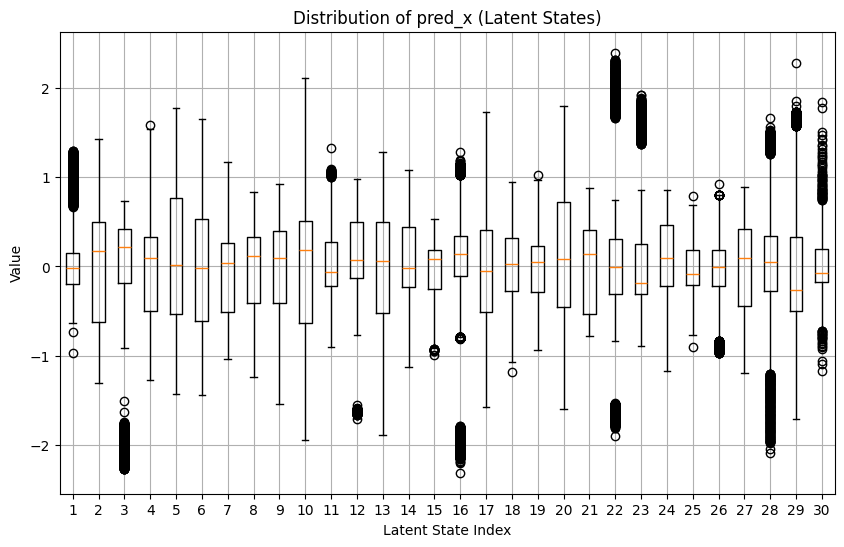

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot(pred_x.T)
plt.title('Distribution of pred_x (Latent States)')
plt.xlabel('Latent State Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()